In [2]:
import warnings
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from cuml.linear_model import LogisticRegression as cumlLogisticRegression
from cuml.svm import SVC as cumlSVC
from cuml.neighbors import KNeighborsClassifier as cumlKNeighborsClassifier
from cuml.ensemble import RandomForestClassifier as cumlRandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [3]:
# Ignore all future and user warnings 
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))

In [4]:
# Reading dataset csv into pandas df
df = pd.read_csv("data/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.shape

(284807, 31)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
# Defining a class for EDA of dataset
class EDA:
    def __init__(self, dataset):
        self.df = dataset

    def display_info(self):
        # Display basic information about the dataset
        info_df = pd.DataFrame({
            'Data Type': self.df.dtypes,
            'Unique Values': self.df.nunique()
        })
        return info_df

    def display_summary_statistics(self):
        # Display summary statistics of numerical columns
        summary_stats = self.df.describe().transpose()
        return summary_stats

    def display_missing_values(self):
        # Display missing values in the dataset
        missing_values_df = pd.DataFrame({
            'Missing Values': self.df.isnull().sum(),
            'Percentage Missing': (self.df.isnull().sum() / len(self.df)) * 100
        })
        return missing_values_df
    
    def check_duplicates(self):
        # Check for duplicate rows in the dataset
        duplicates = self.df.duplicated()
        num_duplicates = duplicates.sum()
        return num_duplicates

    def drop_duplicates(self):
        # Drop duplicate rows in the dataset if necessary
        self.df.drop_duplicates(ignore_index=True, inplace=True)

    def plot_distribution(self):
        # Plot histograms for all numerical columns in subplots
        numerical_columns = self.df.select_dtypes(include=['int64', 'float64']).columns
        n_cols = 5
        n_rows = int(np.ceil(len(numerical_columns) / n_cols))
        fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 15))

        # Flatten the axes to a 1D array
        axes = axes.flatten()

        # Loop over the subplots and plot the histograms
        for ax, col in zip(axes, numerical_columns):
            sns.histplot(data=self.df, x=col, ax=ax, bins=20, kde=True, color='green') 
            ax.set_title(col, fontsize=14)

        # Remove the empty subplots
        for ax in axes[len(numerical_columns):]:
            ax.remove()

        # Adjust the spacing between subplots
        plt.tight_layout()

        plt.show()
    
    def plot_correlation_heatmap(self):
        # Set the figure size
        plt.figure(figsize=(20, 14))
        
        # Create a heatmap with a different color map
        ax = plt.axes()
        sns.heatmap(self.df.corr(), cmap='YlGnBu', annot=True, fmt='.2f')

        # Set title and adjust padding
        ax.set_title('Correlation Heatmap Between Features in the Dataset', fontsize=14, pad=10)

        # Show the plot
        plt.show()
        
    def visualize_correlation_thresholds(self, positive_threshold=0.25, negative_threshold=-0.25):
        correlation_matrix = self.df.corr()

        # Create subplots for positive and negative correlations
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

        # Plot highly positive correlations
        sns.heatmap(correlation_matrix[correlation_matrix > positive_threshold], annot=True, cmap="YlGnBu", fmt=".2f", ax=ax1)
        ax1.set_title("Highly Positive Correlations")

        # Plot highly negative correlations
        sns.heatmap(correlation_matrix[correlation_matrix < negative_threshold], annot=True, cmap="YlGnBu", fmt=".2f", ax=ax2)
        ax2.set_title("Highly Negative Correlations")

        plt.tight_layout()
        plt.show()
    
    def visualize_correlation_with_target(self, target_column):
        # Calculate correlation coefficients
        correlation_matrix = self.df.corr()
        correlation_with_target = correlation_matrix[target_column].sort_values(ascending=False)
        
        # Define a palette similar to 'YlGnBu'
        palette = ['lightgreen', 'mediumseagreen', 'forestgreen', 'darkgreen']

        # Visualize correlations using a bar chart
        plt.figure(figsize=(12, 8))
        sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index, orient='h', palette=palette)
        plt.title(f"Correlation with {target_column}")
        plt.show()
    
    def plot_target_distribution(self, target_variable):
        # Plotting value counts of the target variable by using countplot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10))

        # Custom color palette for the countplot
        countplot_palette = ['lightgreen', 'lightcoral']

        sns.countplot(data=self.df, x=target_variable, ax=ax1, palette=countplot_palette)
        ax1.set_title(f"{target_variable} Distribution")

        # Annotate each bar with the count
        for p in ax1.patches:
            ax1.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', xytext=(0, 10), textcoords='offset points')

        # Custom colors for the pie chart
        pie_chart_colors = ['lightgreen', 'lightcoral']

        labels = self.df[target_variable].value_counts().index
        sizes = self.df[target_variable].value_counts()
        ax2.pie(sizes, labels=labels, autopct='%.02f%%', colors=pie_chart_colors)
        ax2.set_title(f"{target_variable} Proportion")

        # Adjust spacing and layout
        fig.subplots_adjust(wspace=0.5, right=0.8)

        plt.show()

In [7]:
# Initializing object from class EDA
eda = EDA(df)

In [8]:
eda.display_info()

,Data Type,Unique Values
Time,float64,124592
V1,float64,275663
V2,float64,275663
V3,float64,275663
V4,float64,275663
V5,float64,275663
V6,float64,275663
V7,float64,275663
V8,float64,275663
V9,float64,275663


In [9]:
eda.display_summary_statistics()

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


In [10]:
eda.display_missing_values()

,Missing Values,Percentage Missing
Time,0,0.0
V1,0,0.0
V2,0,0.0
V3,0,0.0
V4,0,0.0
V5,0,0.0
V6,0,0.0
V7,0,0.0
V8,0,0.0
V9,0,0.0


In [11]:
# Check for duplicates
num_duplicates = eda.check_duplicates()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 1081


In [12]:
# Drop duplicates
eda.drop_duplicates()

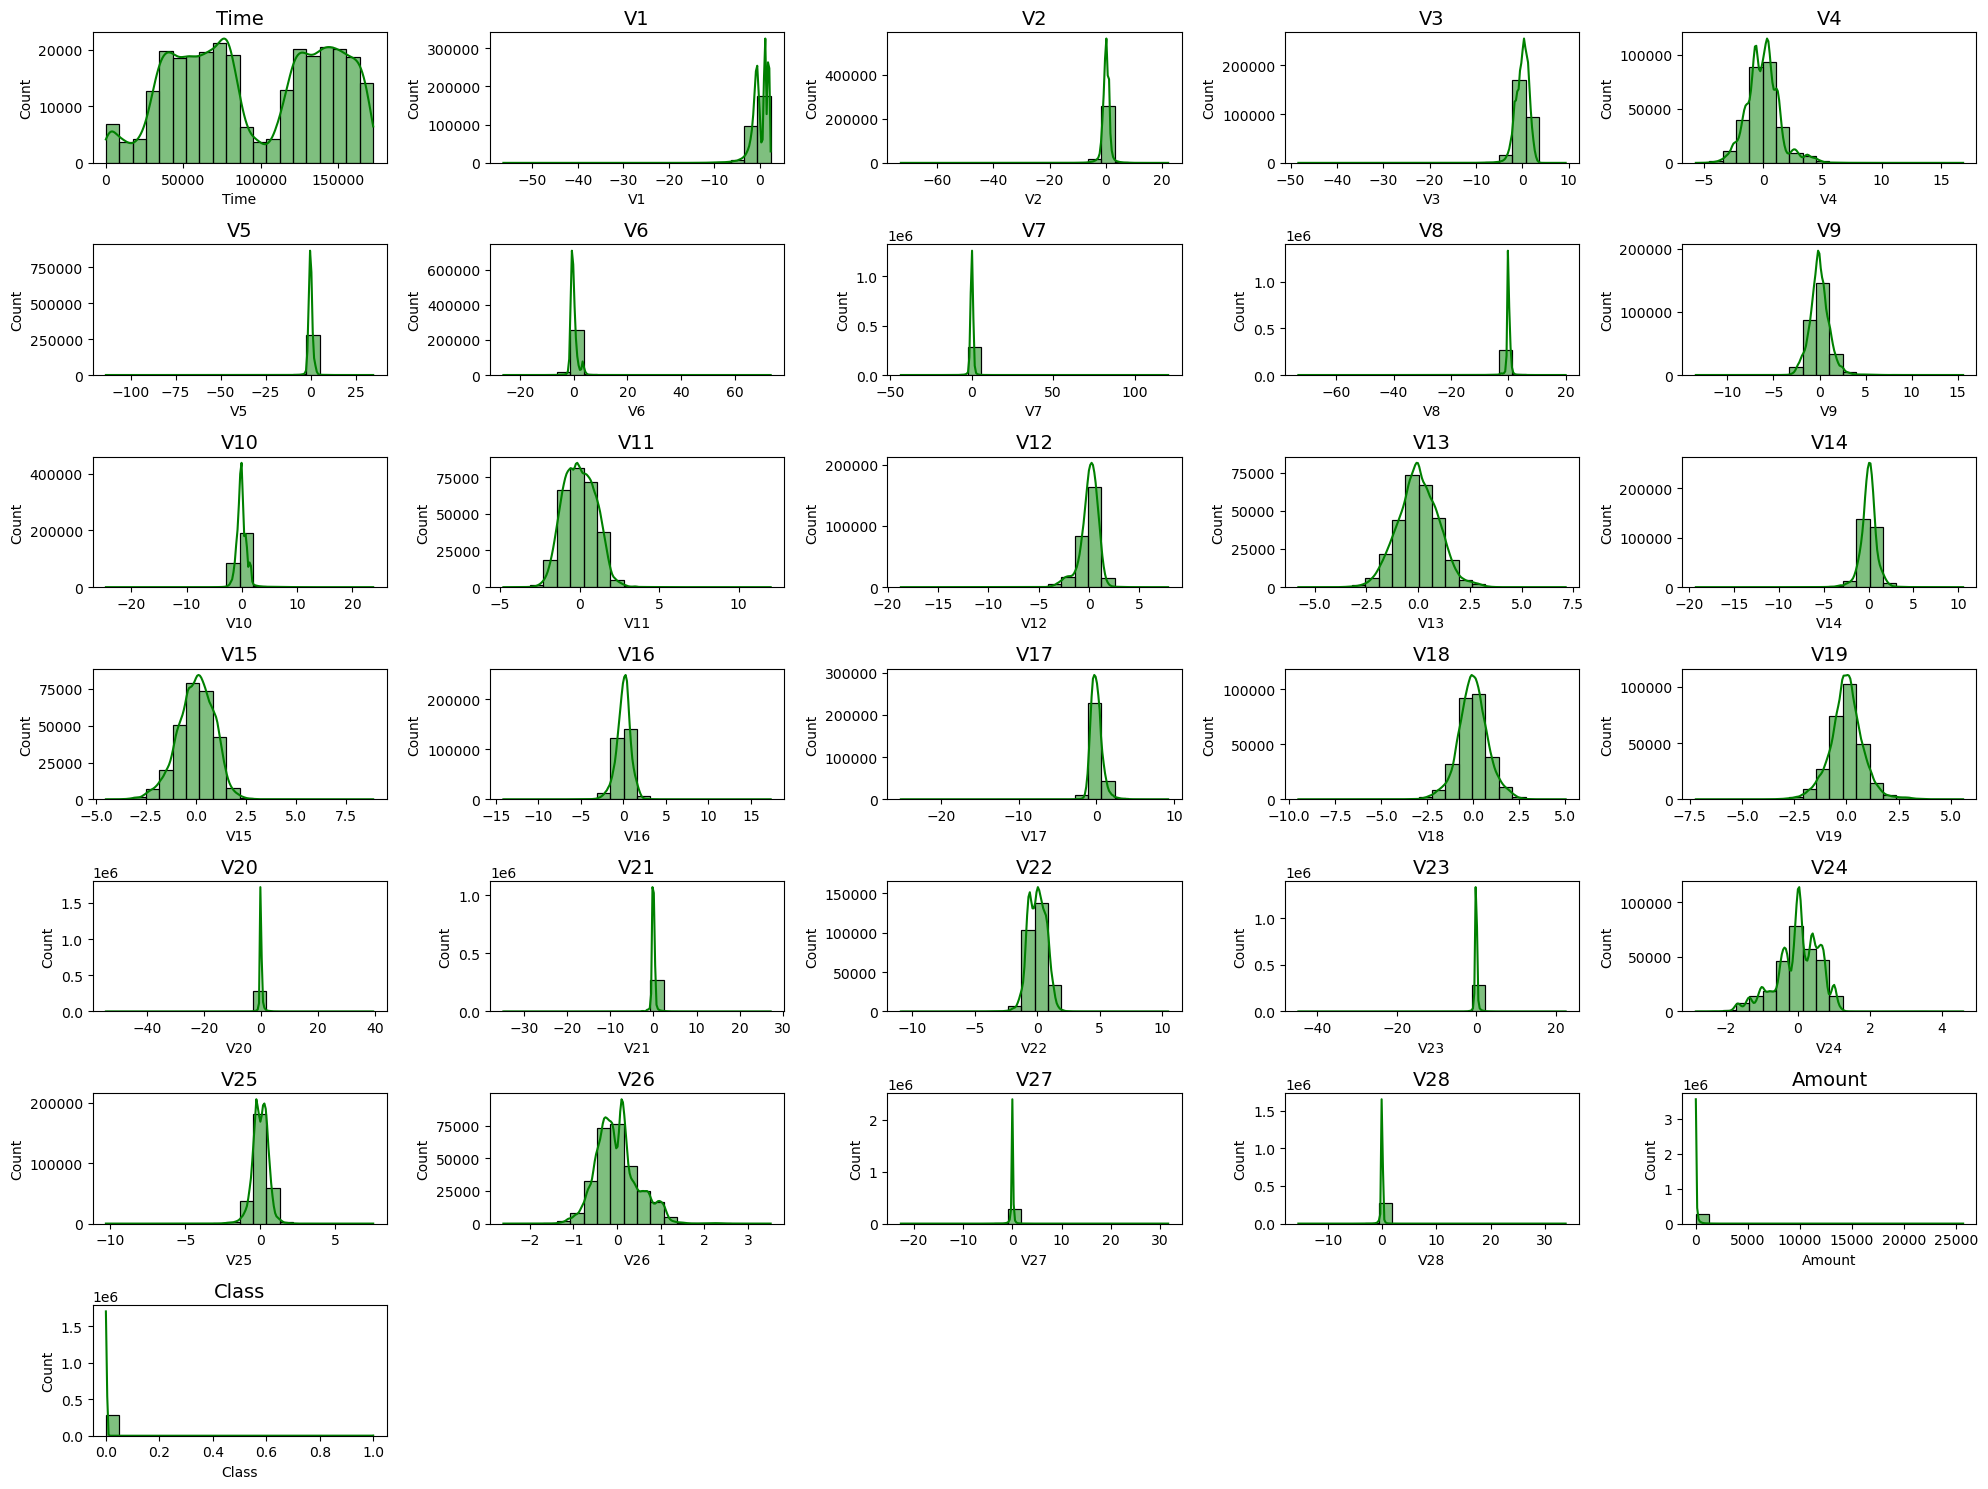

In [13]:
eda.plot_distribution()

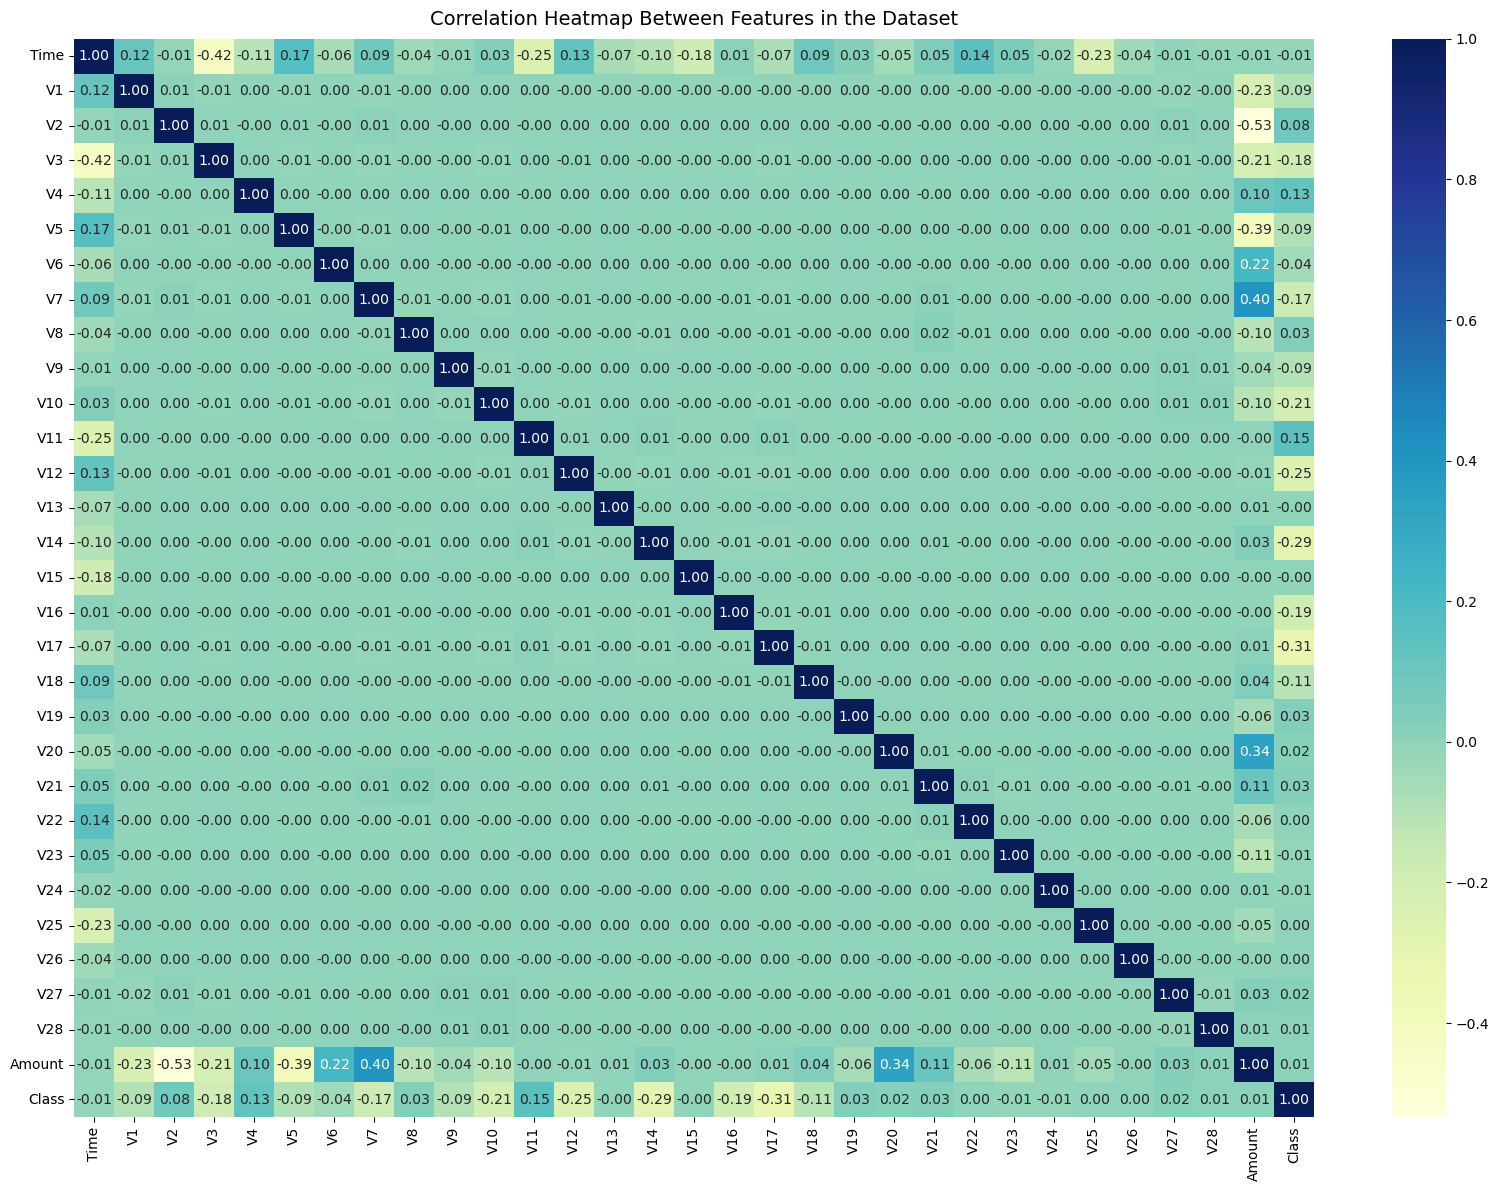

In [14]:
eda.plot_correlation_heatmap()

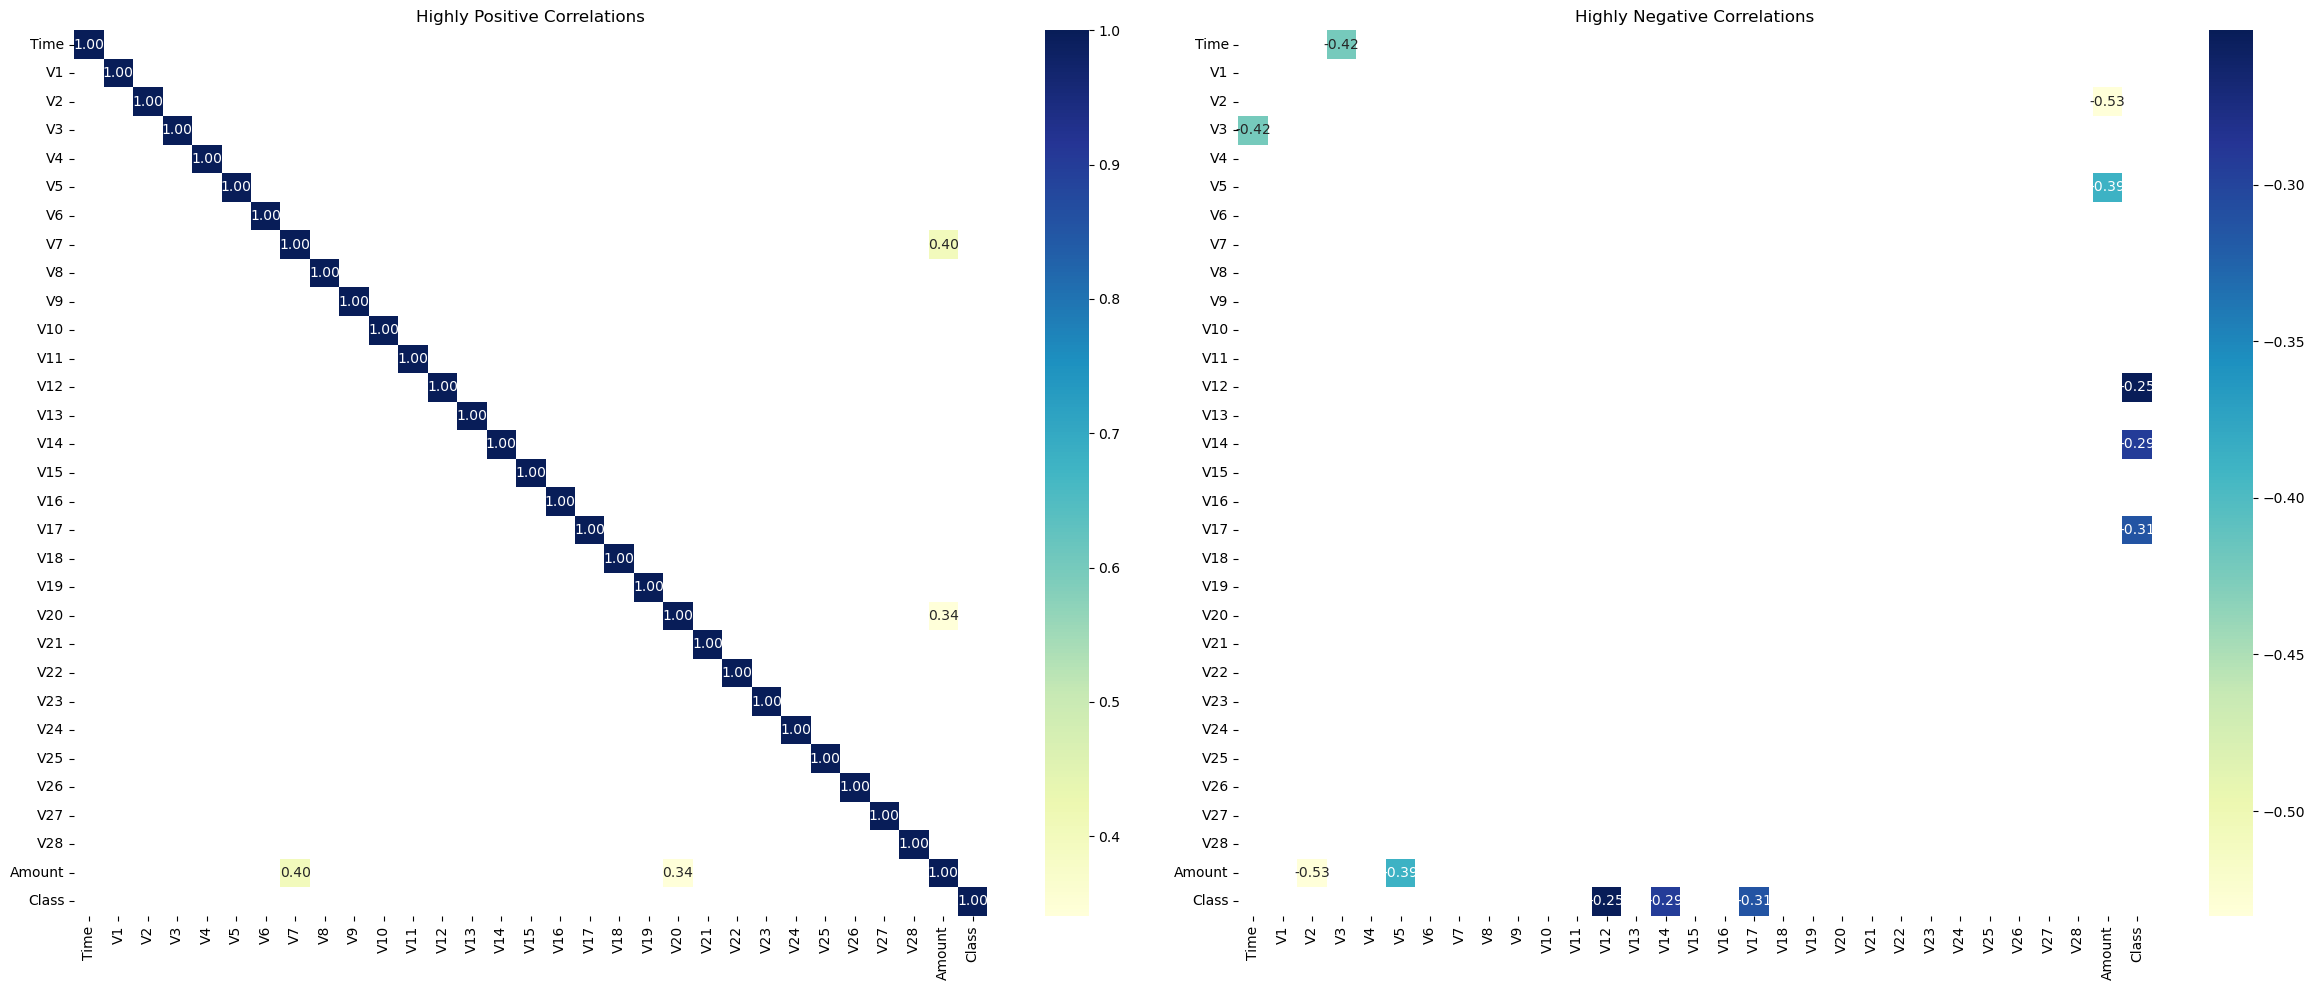

In [15]:
eda.visualize_correlation_thresholds()

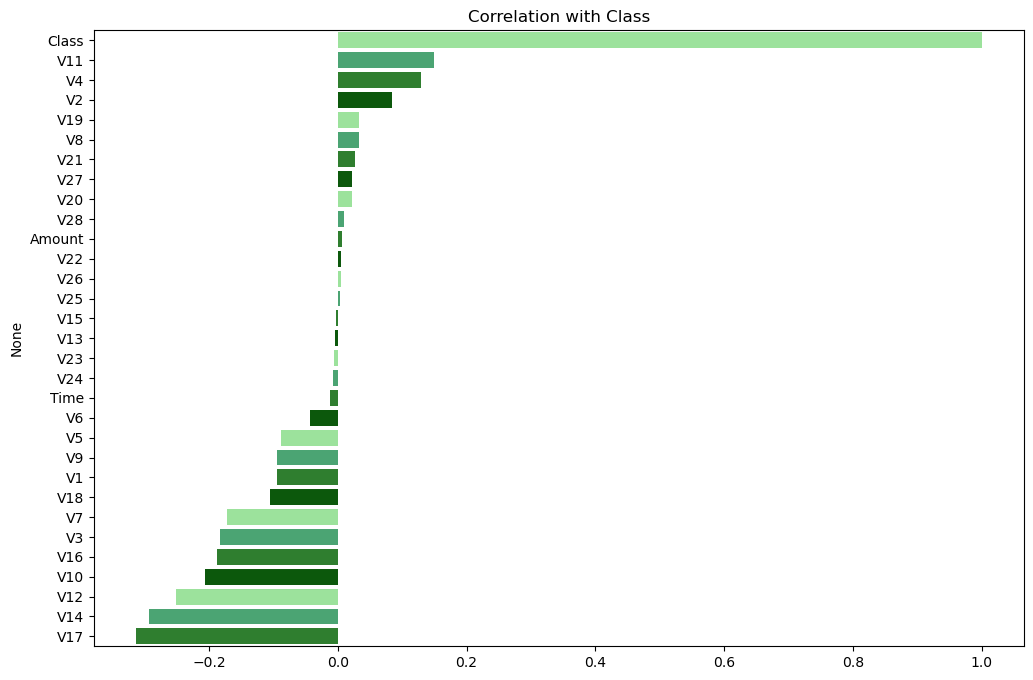

In [16]:
eda.visualize_correlation_with_target('Class')

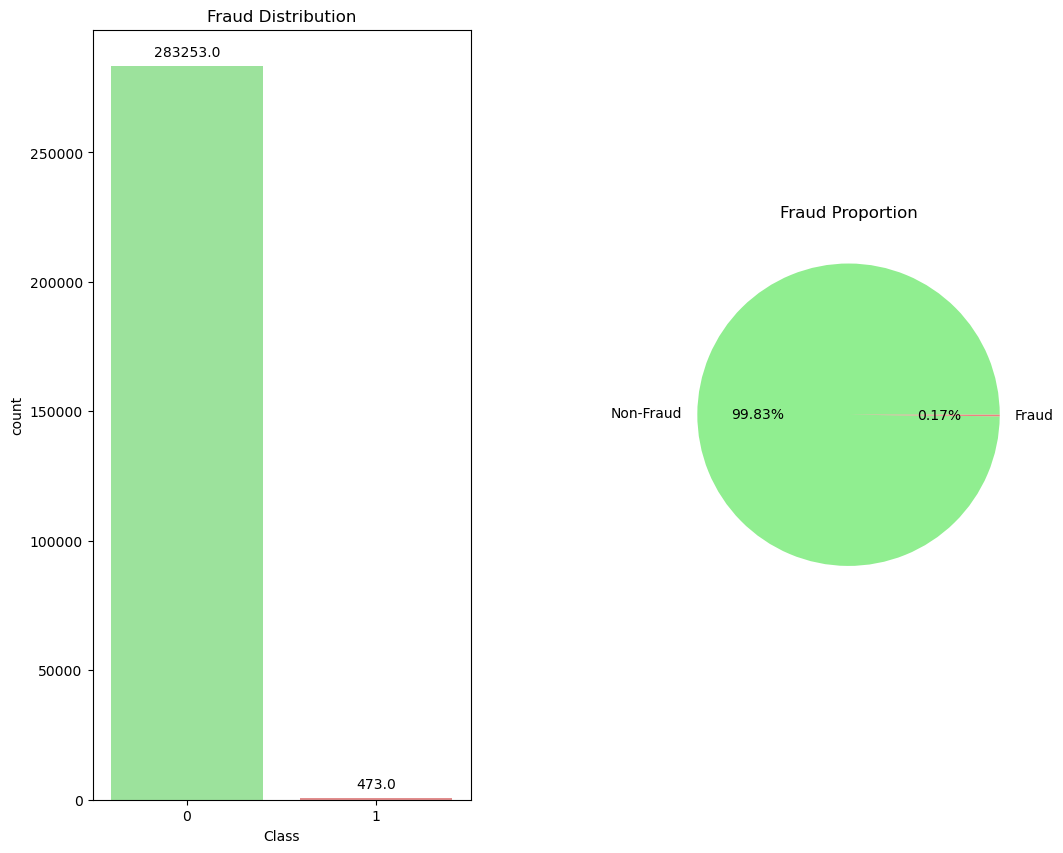

In [17]:
# Custom colors for the count plot
count_plot_palette = ['lightgreen', 'lightcoral']

# Plotting value counts of 'Class' using countplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10))

sns.countplot(data=df, x='Class', ax=ax1, palette=count_plot_palette)
ax1.set_title("Fraud Distribution")

# Annotate each bar with the count
for p in ax1.patches:
    ax1.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Custom colors for the pie chart
pie_chart_palette = ['lightgreen', 'lightcoral']

labels = ["Non-Fraud", "Fraud"]
sizes = df['Class'].value_counts()
ax2.pie(sizes, labels=labels, autopct='%.02f%%', colors=pie_chart_palette)
ax2.set_title("Fraud Proportion")

# Adjust spacing and layout
fig.subplots_adjust(wspace=0.5, right=0.8)

plt.show()

In [18]:
# Drop the 'Time' column
df = df.drop(columns=['Time'])
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [19]:
# Defining a class for data preprocessing
class DataPreprocessor:
    def __init__(self, numerical_columns, categorical_columns, target_column):
        self.numerical_columns = numerical_columns
        self.categorical_columns = categorical_columns
        self.target_column = target_column
        self.scaler = StandardScaler()

    def fit_transform(self, df):
        # One-hot encode categorical variables
        df = self.one_hot_encode_categorical(df)

        # Scale numerical features
        df = self.scale_numerical_features(df)

        return df
    
    def one_hot_encode_categorical(self, df):
        # One-hot encode categorical variables
        df = pd.get_dummies(df, columns=self.categorical_columns, drop_first=True)
        return df

    def scale_numerical_features(self, df):
        # Exclude the target column from numerical scaling
        numerical_columns_except_target = [col for col in self.numerical_columns if col != self.target_column]

        # Scale the numerical features
        df[numerical_columns_except_target] = self.scaler.fit_transform(df[numerical_columns_except_target])
        return df

In [20]:
# Data preprocessing
target_column = 'Class'
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

# Instantiate the DataPreprocessor
preprocessor = DataPreprocessor(numerical_columns, categorical_columns, target_column)

# Extract the target column and drop it from the original DataFrame
y = df[target_column]
df.drop(columns=[target_column], inplace=True)

# Fit and transform the dataset
df_preprocessed = preprocessor.fit_transform(df)
# Add the target column back to the preprocessed DataFrame
df_preprocessed[target_column] = y  
df_preprocessed.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.701082,-0.041687,1.680101,0.976623,-0.247020,0.348012,0.193700,0.084434,0.333534,0.085688,...,-0.024777,0.383483,-0.177444,0.110157,0.247059,-0.392622,0.333033,-0.065850,0.244200,0
1,0.608792,0.164138,0.109279,0.318998,0.042258,-0.060980,-0.065656,0.072903,-0.231703,-0.153784,...,-0.311372,-0.881454,0.162081,-0.561503,0.321175,0.260854,-0.027154,0.043219,-0.342584,0
2,-0.700336,-0.811337,1.174270,0.270648,-0.366756,1.352655,0.643223,0.210788,-1.381169,0.194242,...,0.343094,1.065068,1.457772,-1.138484,-0.628161,-0.288861,-0.144325,-0.183824,1.158900,0
3,-0.499064,-0.109972,1.187383,-0.608355,-0.008814,0.937245,0.192079,0.320843,-1.264664,-0.049713,...,-0.149093,0.007299,-0.305465,-1.941446,1.242487,-0.460694,0.154039,0.185687,0.139886,0
4,-0.597606,0.535539,1.025470,0.287092,-0.297036,0.072873,0.481517,-0.228725,0.747917,0.700958,...,-0.012516,1.101780,-0.220709,0.232904,-0.394800,1.041677,0.550001,0.654234,-0.073813,0


In [21]:
# Defining a class for model evaluation
class ModelEvaluator:
    def __init__(self, model, X_test, y_test):
        self.model = model
        self.X_test = X_test
        self.y_test = y_test

    def plot_confusion_matrix(self, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(4, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    def evaluate(self):
        y_pred = self.model.predict(self.X_test)
       
        # Accuracy
        accuracy = accuracy_score(self.y_test, y_pred)
        print(f"Accuracy: {accuracy:.2f}")

        # Classification Report
        print("Classification Report:\n", classification_report(self.y_test, y_pred))
        
        # Confusion Matrix
        self.plot_confusion_matrix(self.y_test, y_pred)

In [22]:
# Setting target and features from preprocessed dataset
X = df_preprocessed.drop(columns=['Class'])
y = df_preprocessed['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (226980, 29)
X_test shape: (56746, 29)
y_train shape: (226980,)
y_test shape: (56746,)


Logistic Regression Model Evaluation:

Accuracy: 1.00
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56656
           1       0.89      0.54      0.68        90

    accuracy                           1.00     56746
   macro avg       0.95      0.77      0.84     56746
weighted avg       1.00      1.00      1.00     56746



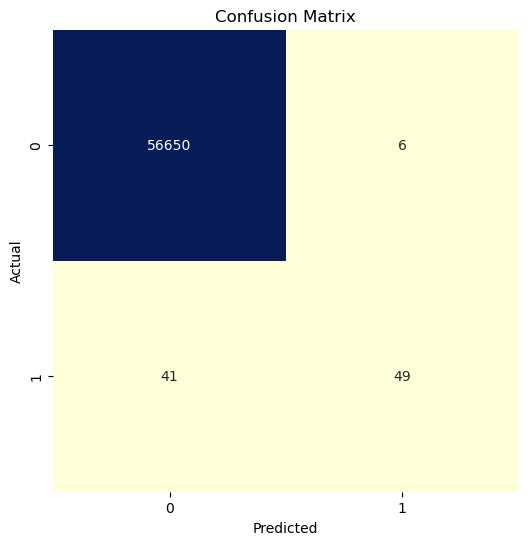

Runtime: 1.6796 seconds

Random Forest Model Evaluation:

Accuracy: 1.00
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56656
           1       0.97      0.73      0.84        90

    accuracy                           1.00     56746
   macro avg       0.99      0.87      0.92     56746
weighted avg       1.00      1.00      1.00     56746



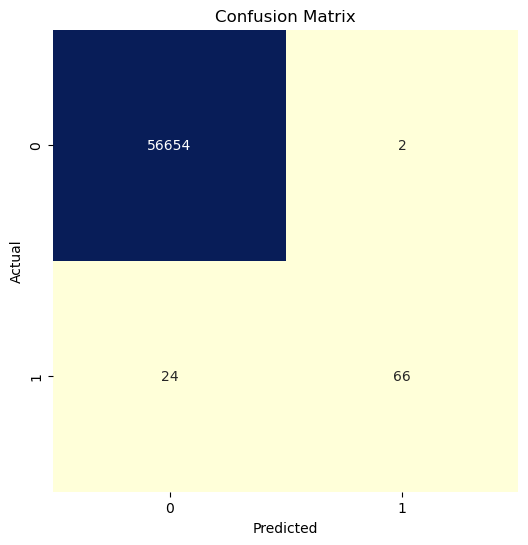

Runtime: 198.7977 seconds

Support Vector Machine Model Evaluation:

Accuracy: 1.00
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56656
           1       0.98      0.63      0.77        90

    accuracy                           1.00     56746
   macro avg       0.99      0.82      0.88     56746
weighted avg       1.00      1.00      1.00     56746



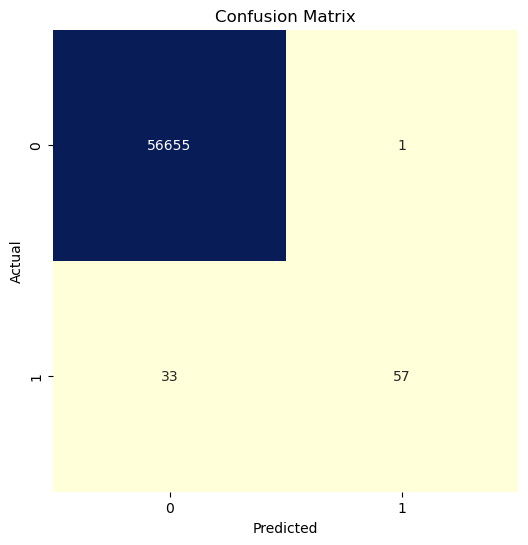

Runtime: 188.8008 seconds

K-Nearest Neighbors Model Evaluation:

Accuracy: 1.00
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56656
           1       0.95      0.70      0.81        90

    accuracy                           1.00     56746
   macro avg       0.98      0.85      0.90     56746
weighted avg       1.00      1.00      1.00     56746



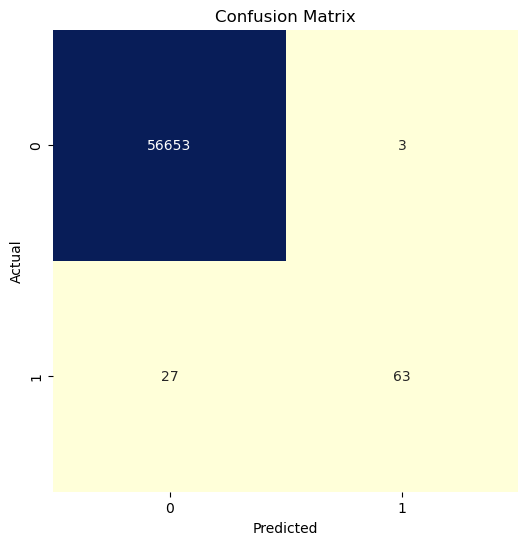

Runtime: 0.0282 seconds



In [23]:
# Create classifiers
classifiers_sklearn = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Support Vector Machine': SVC(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier()
}
# Dictionary to store runtime information
sklearn_runtimes = {}

# Train and evaluate each scikit-learn model
for name, model in classifiers_sklearn.items():
    start_time = time.time()
    pipeline = make_pipeline(model)
    pipeline.fit(X_train, y_train)
    end_time = time.time()
    elapsed_time = end_time - start_time
    sklearn_runtimes[name] = elapsed_time
    print(f"{name} Model Evaluation:\n")
    model_evaluator = ModelEvaluator(pipeline, X_test, y_test)
    model_evaluator.evaluate()
    print(f"Runtime: {elapsed_time:.4f} seconds\n")

Logistic Regression cuML Model Evaluation:

Accuracy: 1.00
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56656
           1       0.89      0.54      0.68        90

    accuracy                           1.00     56746
   macro avg       0.95      0.77      0.84     56746
weighted avg       1.00      1.00      1.00     56746



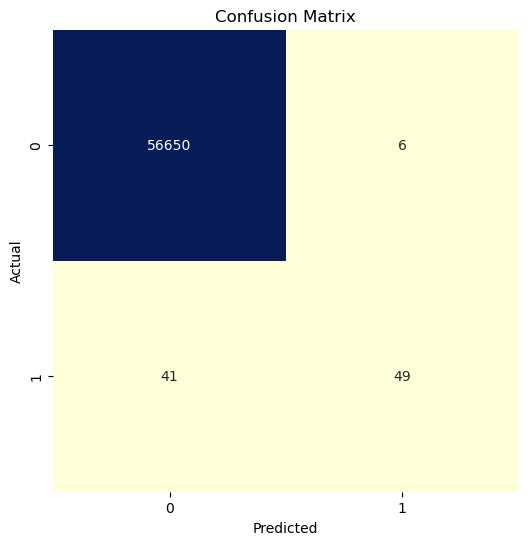

Runtime: 1.2002 seconds

Random Forest cuML Model Evaluation:

Accuracy: 1.00
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56656
           1       0.97      0.69      0.81        90

    accuracy                           1.00     56746
   macro avg       0.98      0.84      0.90     56746
weighted avg       1.00      1.00      1.00     56746



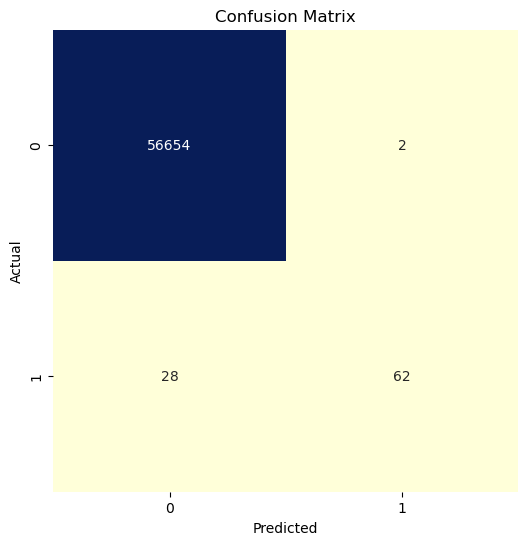

Runtime: 2.7977 seconds

Support Vector Machine cuML Model Evaluation:

Accuracy: 1.00
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56656
           1       0.98      0.63      0.77        90

    accuracy                           1.00     56746
   macro avg       0.99      0.82      0.88     56746
weighted avg       1.00      1.00      1.00     56746



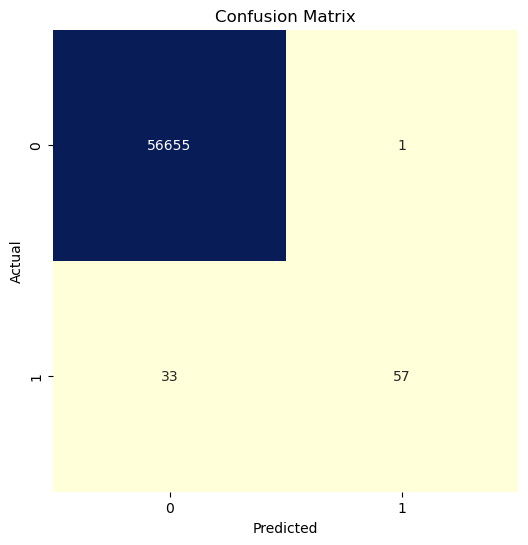

Runtime: 2.7905 seconds

K-Nearest Neighbors cuML Model Evaluation:

Accuracy: 1.00
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56656
           1       0.95      0.70      0.81        90

    accuracy                           1.00     56746
   macro avg       0.98      0.85      0.90     56746
weighted avg       1.00      1.00      1.00     56746



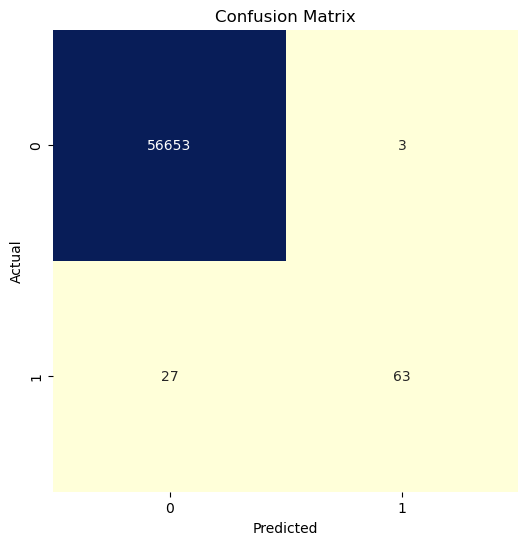

Runtime: 0.0457 seconds



In [24]:
# Create classifiers
classifiers_cuml = {
    'Logistic Regression': cumlLogisticRegression(),
    'Random Forest': cumlRandomForestClassifier(random_state=42),
    'Support Vector Machine': cumlSVC(),
    'K-Nearest Neighbors': cumlKNeighborsClassifier()
    
}
# Dictionary to store runtime information
cuml_runtimes = {}

# Train and evaluate each cuML model
for name, model in classifiers_cuml.items():
    start_time = time.time()
    pipeline = make_pipeline(model)
    pipeline.fit(X_train, y_train)
    end_time = time.time()
    elapsed_time = end_time - start_time
    cuml_runtimes[name] = elapsed_time
    print(f"{name} cuML Model Evaluation:\n")
    cuml_model_evaluator = ModelEvaluator(pipeline, X_test, y_test)
    cuml_model_evaluator.evaluate()
    print(f"Runtime: {elapsed_time:.4f} seconds\n")

In [25]:
# Convert dictionaries to Pandas Series
sklearn_series = pd.Series(sklearn_runtimes, name='Sklearn Runtime (seconds)')
cuml_series = pd.Series(cuml_runtimes, name='CuML Runtime (seconds)')

# Combine the two Series into a single DataFrame
df_runtimes = pd.DataFrame({'Model': sklearn_series.index, 'Sklearn Runtime (seconds)': sklearn_series.values, 'CuML Runtime (seconds)': cuml_series.values})

# Display the resulting DataFrame
print(df_runtimes)

                    Model  Sklearn Runtime (seconds)  CuML Runtime (seconds)
0     Logistic Regression                   1.679562                1.200249
1           Random Forest                 198.797719                2.797668
2  Support Vector Machine                 188.800817                2.790456
3     K-Nearest Neighbors                   0.028155                0.045742


Logistic Regression Model Evaluation:

Accuracy: 0.98
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     56656
           1       0.06      0.88      0.11        90

    accuracy                           0.98     56746
   macro avg       0.53      0.93      0.55     56746
weighted avg       1.00      0.98      0.99     56746



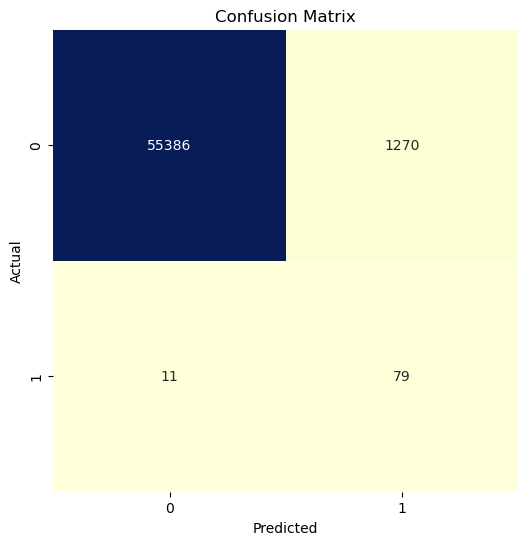

Runtime: 1.7526 seconds

Random Forest Model Evaluation:

Accuracy: 1.00
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56656
           1       0.98      0.72      0.83        90

    accuracy                           1.00     56746
   macro avg       0.99      0.86      0.92     56746
weighted avg       1.00      1.00      1.00     56746



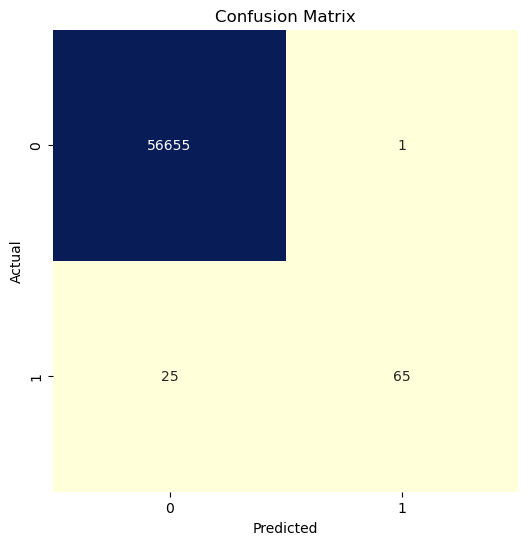

Runtime: 105.0405 seconds

Support Vector Machine Model Evaluation:

Accuracy: 1.00
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56656
           1       0.36      0.69      0.48        90

    accuracy                           1.00     56746
   macro avg       0.68      0.84      0.74     56746
weighted avg       1.00      1.00      1.00     56746



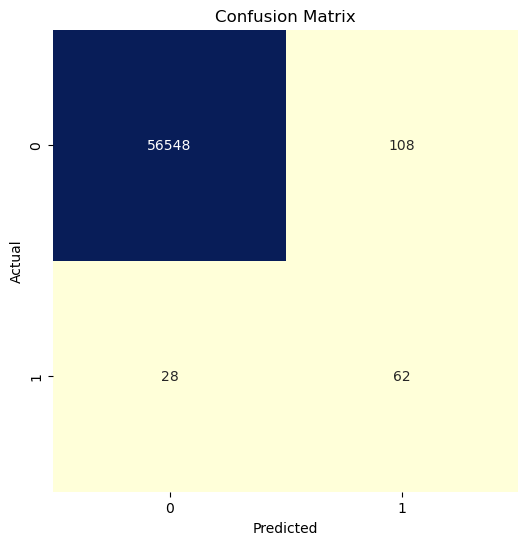

Runtime: 66.3394 seconds

K-Nearest Neighbors Model Evaluation:

Accuracy: 1.00
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56656
           1       0.96      0.71      0.82        90

    accuracy                           1.00     56746
   macro avg       0.98      0.86      0.91     56746
weighted avg       1.00      1.00      1.00     56746



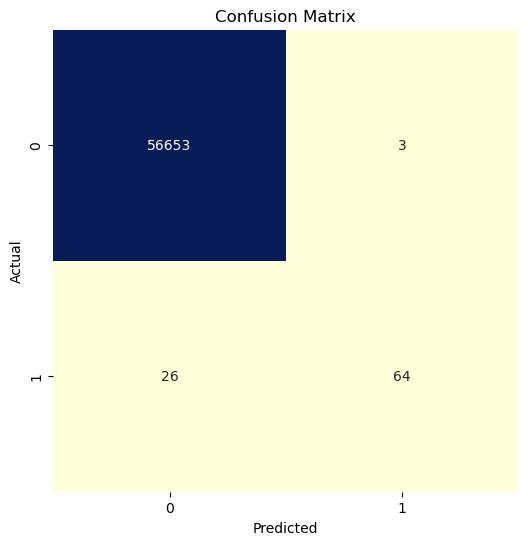

Runtime: 0.0174 seconds



In [26]:
# Classification with class weights

# Calculate class weights
class_weights = {0: 1 / 0.9983, 1: 1 / 0.0017}

# Create classifiers with class weights
classifiers_sklearn = {
    'Logistic Regression': LogisticRegression(random_state=42, class_weight=class_weights),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight=class_weights),
    'Support Vector Machine': SVC(random_state=42, class_weight=class_weights),
    'K-Nearest Neighbors': KNeighborsClassifier(weights='distance')
}

# Train and evaluate each scikit-learn model
for name, model in classifiers_sklearn.items():
    start_time = time.time()
    pipeline = make_pipeline(model)
    pipeline.fit(X_train, y_train)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"{name} Model Evaluation:\n")
    model_evaluator = ModelEvaluator(pipeline, X_test, y_test)
    model_evaluator.evaluate()
    print(f"Runtime: {elapsed_time:.4f} seconds\n")

Gradient Boosting Model Evaluation:

Accuracy: 1.00
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56656
           1       0.89      0.63      0.74        90

    accuracy                           1.00     56746
   macro avg       0.95      0.82      0.87     56746
weighted avg       1.00      1.00      1.00     56746



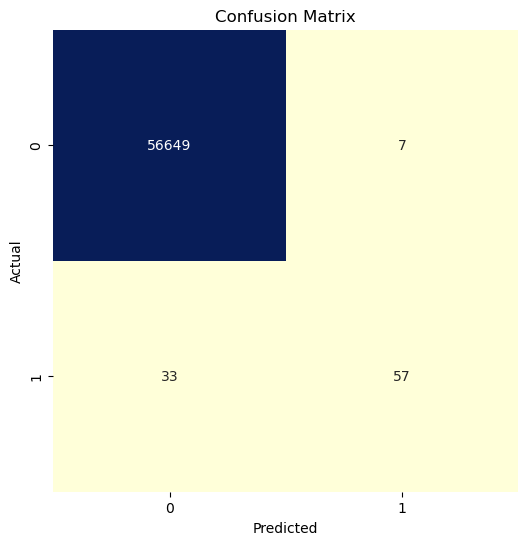

Runtime: 315.3257 seconds

XGBoost Model Evaluation:

Accuracy: 1.00
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56656
           1       0.96      0.74      0.84        90

    accuracy                           1.00     56746
   macro avg       0.98      0.87      0.92     56746
weighted avg       1.00      1.00      1.00     56746



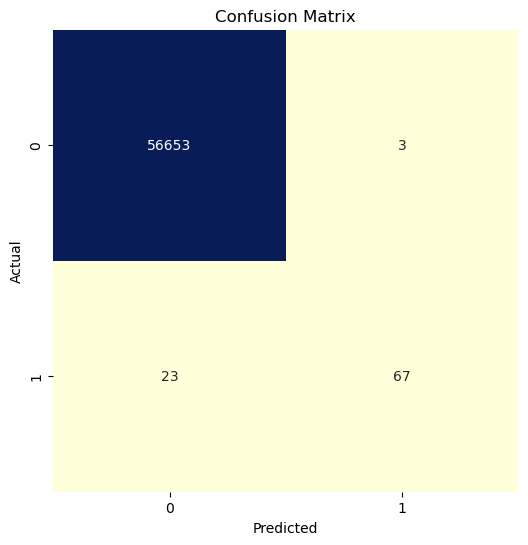

Runtime: 18.0210 seconds

CatBoost Model Evaluation:

Accuracy: 1.00
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56656
           1       0.86      0.81      0.83        90

    accuracy                           1.00     56746
   macro avg       0.93      0.91      0.92     56746
weighted avg       1.00      1.00      1.00     56746



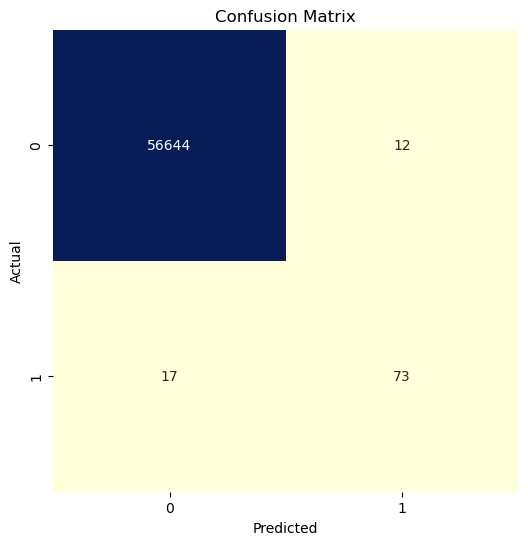

Runtime: 20.6274 seconds



In [27]:
# Classifiers 
classifiers = {
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0, class_weights={0: 1 / 0.9983, 1: 1 / 0.0017})
}

# Train and evaluate each scikit-learn model
for name, model in classifiers.items():
    start_time = time.time()
    pipeline = make_pipeline(model)
    pipeline.fit(X_train, y_train)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"{name} Model Evaluation:\n")
    model_evaluator = ModelEvaluator(pipeline, X_test, y_test)
    model_evaluator.evaluate()
    print(f"Runtime: {elapsed_time:.4f} seconds\n")

Logistic Regression cuML Model Evaluation:

Accuracy: 0.99
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     56656
           1       0.10      0.86      0.18        90

    accuracy                           0.99     56746
   macro avg       0.55      0.92      0.59     56746
weighted avg       1.00      0.99      0.99     56746



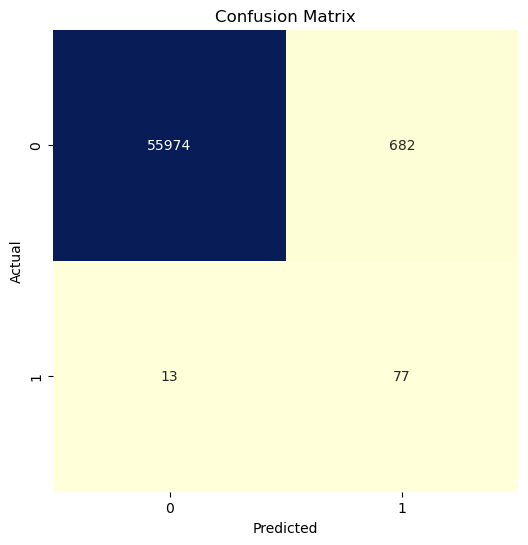

Runtime: 0.6418 seconds

Random Forest cuML Model Evaluation:

Accuracy: 1.00
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56656
           1       0.86      0.78      0.82        90

    accuracy                           1.00     56746
   macro avg       0.93      0.89      0.91     56746
weighted avg       1.00      1.00      1.00     56746



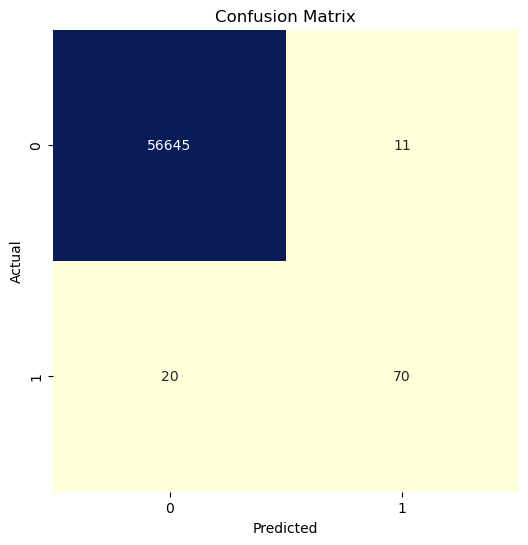

Runtime: 2.8962 seconds

Support Vector Machine cuML Model Evaluation:

Accuracy: 0.99
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56656
           1       0.21      0.80      0.34        90

    accuracy                           0.99     56746
   macro avg       0.61      0.90      0.67     56746
weighted avg       1.00      0.99      1.00     56746



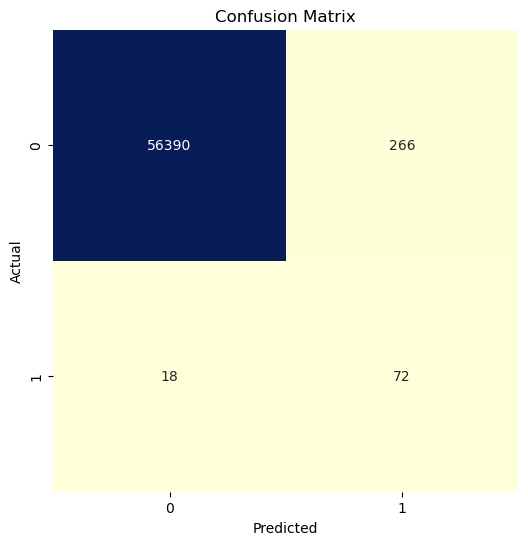

Runtime: 10.7858 seconds

K-Nearest Neighbors cuML Model Evaluation:

Accuracy: 1.00
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56656
           1       0.53      0.80      0.63        90

    accuracy                           1.00     56746
   macro avg       0.76      0.90      0.82     56746
weighted avg       1.00      1.00      1.00     56746



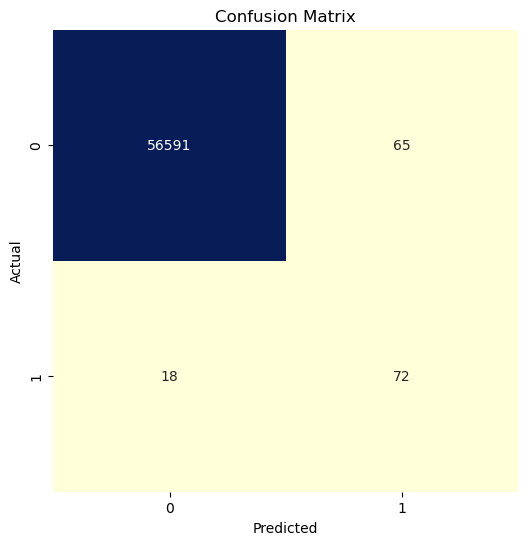

Runtime: 0.0526 seconds



In [28]:
# Define the oversampling technique (SMOTE)
smote = SMOTE(sampling_strategy=0.5, random_state=42)

# Apply oversampling only on the training set
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Create classifiers
classifiers_cuml = {
    'Logistic Regression': cumlLogisticRegression(),
    'Random Forest': cumlRandomForestClassifier(random_state=42),
    'Support Vector Machine': cumlSVC(),
    'K-Nearest Neighbors': cumlKNeighborsClassifier()
    
}

# Train and evaluate each cuML model
for name, model in classifiers_cuml.items():
    start_time = time.time()
    pipeline = make_pipeline(model)
    pipeline.fit(X_train_resampled, y_train_resampled)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"{name} cuML Model Evaluation:\n")
    cuml_model_evaluator = ModelEvaluator(pipeline, X_test, y_test)
    cuml_model_evaluator.evaluate()
    print(f"Runtime: {elapsed_time:.4f} seconds\n")


Logistic Regression cuML Model Evaluation:

Accuracy: 0.98
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     56656
           1       0.07      0.86      0.14        90

    accuracy                           0.98     56746
   macro avg       0.54      0.92      0.56     56746
weighted avg       1.00      0.98      0.99     56746



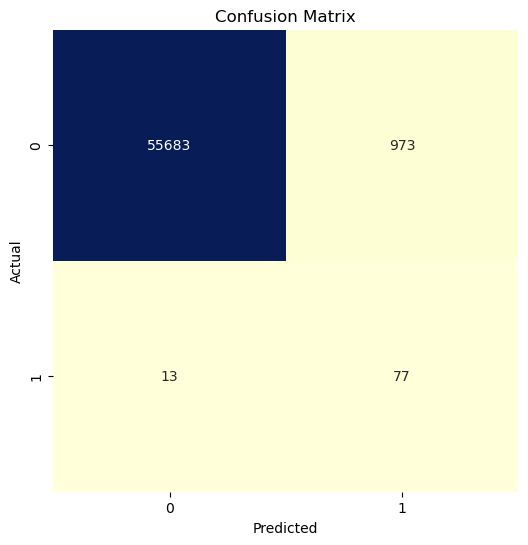

Runtime: 0.0798 seconds

Random Forest cuML Model Evaluation:

Accuracy: 0.99
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     56656
           1       0.16      0.84      0.27        90

    accuracy                           0.99     56746
   macro avg       0.58      0.92      0.63     56746
weighted avg       1.00      0.99      1.00     56746



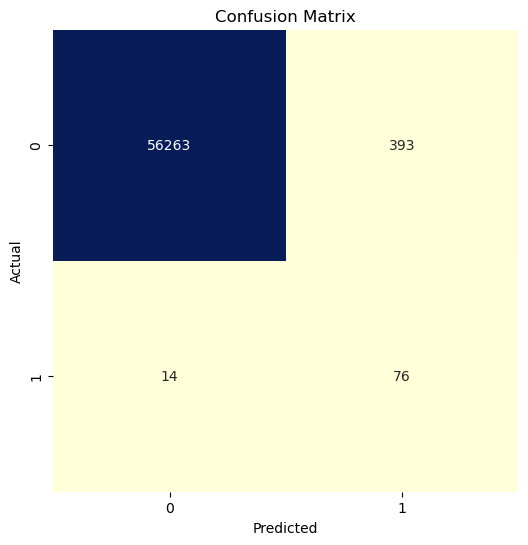

Runtime: 0.4001 seconds

Support Vector Machine cuML Model Evaluation:

Accuracy: 0.99
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     56656
           1       0.11      0.84      0.20        90

    accuracy                           0.99     56746
   macro avg       0.56      0.92      0.60     56746
weighted avg       1.00      0.99      0.99     56746



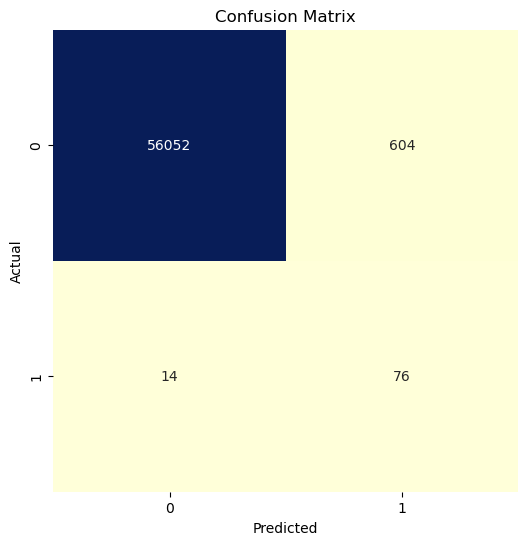

Runtime: 0.0680 seconds

K-Nearest Neighbors cuML Model Evaluation:

Accuracy: 0.99
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     56656
           1       0.13      0.84      0.22        90

    accuracy                           0.99     56746
   macro avg       0.56      0.92      0.61     56746
weighted avg       1.00      0.99      0.99     56746



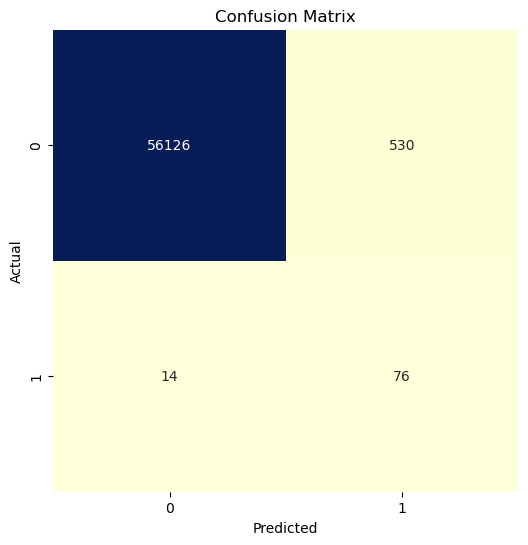

Runtime: 0.0052 seconds



In [29]:
# Define the undersampling technique (RandomUnderSampler)
undersampler = RandomUnderSampler(sampling_strategy=0.5, random_state=42)

# Apply undersampling only on the training set
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Create classifiers
classifiers_cuml = {
    'Logistic Regression': cumlLogisticRegression(),
    'Random Forest': cumlRandomForestClassifier(random_state=42),
    'Support Vector Machine': cumlSVC(),
    'K-Nearest Neighbors': cumlKNeighborsClassifier()
    
}

# Train and evaluate each cuML model
for name, model in classifiers_cuml.items():
    start_time = time.time()
    pipeline = make_pipeline(model)
    pipeline.fit(X_train_resampled, y_train_resampled)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"{name} cuML Model Evaluation:\n")
    cuml_model_evaluator = ModelEvaluator(pipeline, X_test, y_test)
    cuml_model_evaluator.evaluate()
    print(f"Runtime: {elapsed_time:.4f} seconds\n")


Logistic Regression cuML Model Evaluation:

Accuracy: 0.98
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     56656
           1       0.06      0.87      0.12        90

    accuracy                           0.98     56746
   macro avg       0.53      0.92      0.55     56746
weighted avg       1.00      0.98      0.99     56746



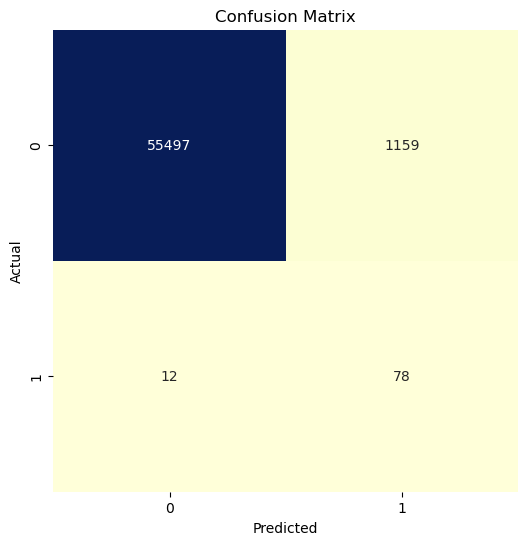

Runtime: 0.4666 seconds

Random Forest cuML Model Evaluation:

Accuracy: 1.00
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56656
           1       0.80      0.78      0.79        90

    accuracy                           1.00     56746
   macro avg       0.90      0.89      0.90     56746
weighted avg       1.00      1.00      1.00     56746



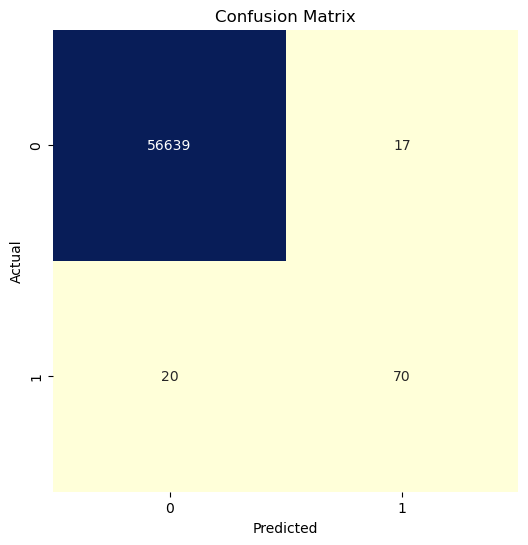

Runtime: 3.3584 seconds

Support Vector Machine cuML Model Evaluation:

Accuracy: 0.99
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     56656
           1       0.10      0.83      0.18        90

    accuracy                           0.99     56746
   macro avg       0.55      0.91      0.59     56746
weighted avg       1.00      0.99      0.99     56746



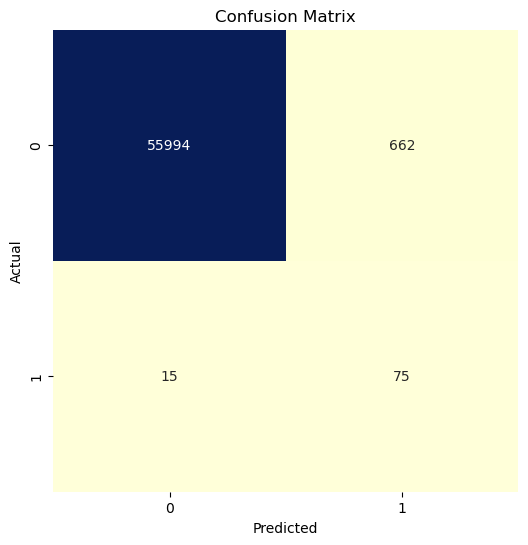

Runtime: 17.3039 seconds

K-Nearest Neighbors cuML Model Evaluation:

Accuracy: 1.00
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56656
           1       0.52      0.80      0.63        90

    accuracy                           1.00     56746
   macro avg       0.76      0.90      0.82     56746
weighted avg       1.00      1.00      1.00     56746



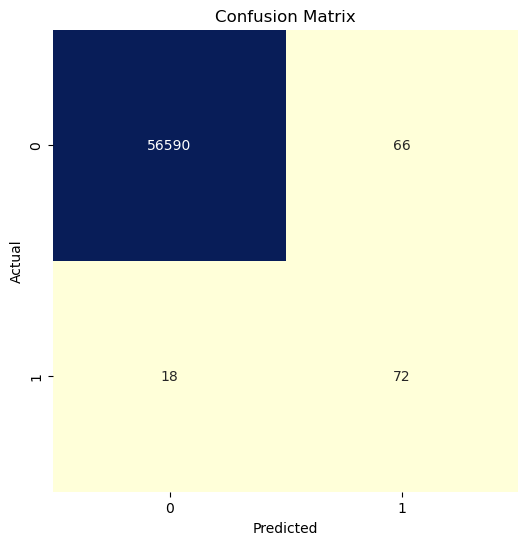

Runtime: 0.0618 seconds



In [31]:
# Define the oversampling technique (SMOTE)
smote = SMOTE(sampling_strategy=0.81, random_state=42)

# Apply oversampling only on the training set
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Create classifiers
classifiers_cuml = {
    'Logistic Regression': cumlLogisticRegression(),
    'Random Forest': cumlRandomForestClassifier(random_state=42),
    'Support Vector Machine': cumlSVC(),
    'K-Nearest Neighbors': cumlKNeighborsClassifier()
    
}

# Train and evaluate each cuML model
for name, model in classifiers_cuml.items():
    start_time = time.time()
    pipeline = make_pipeline(model)
    pipeline.fit(X_train_resampled, y_train_resampled)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"{name} cuML Model Evaluation:\n")
    cuml_model_evaluator = ModelEvaluator(pipeline, X_test, y_test)
    cuml_model_evaluator.evaluate()
    print(f"Runtime: {elapsed_time:.4f} seconds\n")